<a href="https://colab.research.google.com/github/Josephnyingi/Crop-Disease-Detection/blob/main/Crop_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Plants are susceptible to diseases due to factors such as fertilizer use, farming practices, and environmental conditions, which negatively impact agricultural yields and the economy. Early detection of plant diseases is crucial for farmers to cultivate crops effectively and efficiently, both in terms of quality and quantity. Thus, disease detection in plants is a vital aspect of agriculture.

# Download dataset

Initially, we retrieve the PlantVillage dataset from Google Drive using its unique ID, then extract the contents of the downloaded PlantVillage.zip file into the designated PlantVillage dataset folder

# Import Libraries


In [ ]:
#Library
import pandas as pd
import keras
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
!pip install gdown
!apt-get update && apt-get install fil
!pip install keras_preprocessing


# Load the dataset

1. Mount your Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


Copied the dataset to Google Drive: Downloaded the dataset and saved it to Google Drive.
Then accessed the dataset in Colab 

In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/crowdai')

# Checking distribution of labels

Checked the distribution of labels in a dataset as it is an important step in preparing the data for machine learning. This can help you determine if the dataset is balanced or imbalanced, which can have an impact on the performance of your model.

To check the distribution of labels in the Plant Village dataset, you can use the following code:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load the data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


checking the distribution of labels in a dataset is an important step in preparing the data for machine learning. This can help you determine if the dataset is balanced or imbalanced, which can have an impact on the performance of your model.
The code uses the numpy library to count the number of occurrences of each label in the y_train array. The unique_labels variable contains the unique labels in the array, and the count_labels variable contains the number of occurrences of each label.


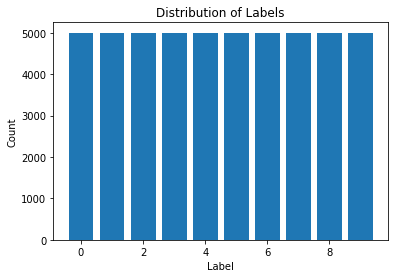

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of occurrences of each label
unique_labels, count_labels = np.unique(y_train, return_counts=True)

# Plot the distribution of labels
plt.bar(unique_labels, count_labels)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()
